# 월간 데이콘 7: EMNIST Baseline Code

## 작성자
JerryKwon <img width=24 src="https://icons-for-free.com/iconfiles/png/512/github+icon-1320168274457504277.png"><a href="https://github.com/JerryKwon ">github</a></img>


## 링크
https://dacon.io/competitions/official/235626/overview/

## Reference
* pytorch 사용법 기초 <br/>
https://greeksharifa.github.io/pytorch/2018/11/10/pytorch-usage-03-How-to-Use-PyTorch/

* pytorch CNN Tutorial <br/>
https://github.com/inmoonlight/PyTorchTutorial/blob/master/01_CNN.ipynb

* pytorch EMNIST Dacon Tutorial <br/>
https://dacon.io/competitions/official/235626/codeshare/1592?page=1&dtype=recent&ptype=pub



## 1. Import Packages

In [118]:
import pandas as pd
import numpy as np
import copy 
import time
import os
import re
import platform
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

import pickle
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

!pip install albumentations
!pip install opencv-python

import albumentations as A
from albumentations.pytorch import ToTensor
from torchvision import transforms

## 2. Load Data

In [2]:
IS_COLAB = True

os_env = platform.system()

if IS_COLAB:
  from google.colab import drive
  drive.mount('/gdrive')

  pj_home = '/gdrive/My Drive/colab/EMNST_DACON'

  if os_env == "Linux":
    data_home = pj_home + "/input/data/"

  elif os_en == "Windows":
    data_home = pj_home + "\\input\\data\\"

else:
  if os_env == "Linux":
      pj_home = "/".join(os.path.abspath(os.path.dirname(os.path.abspath('__file__'))).split("/")[:-1])
      data_home = pj_home + "/input/data/"
      
  elif os_env == "Windows":
      pj_home = "\\".join(os.path.abspath(os.path.dirname(os.path.abspath('__file__'))).split("\\")[:-1])
      data_home = pj_home + "\\input\\data\\"

train = data_home + "train.csv"
test = data_home + "test.csv"

df_train = pd.read_csv(train)
df_test = pd.read_csv(test)

Mounted at /gdrive


In [3]:
df_train.head()

,id,digit,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,4,4,3,0,4,3,3,3,4,4,0,0,1,1,3,4,0,4,2,0,4,0,1,3,1,0,4,1,1,3,...,4,3,4,1,3,0,0,1,3,3,3,0,3,2,2,1,0,1,0,0,3,0,0,4,2,0,3,4,1,1,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,1,4,2,0,3,4,0,0,2,3,4,0,3,4,3,0,2,2,1,4,2,3,3,4,1,2,4,2,0,3,...,4,2,3,0,0,0,0,4,3,2,2,4,2,1,1,1,3,3,1,2,4,4,4,2,2,4,4,0,4,2,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,0,2,1,3,2,2,2,4,1,1,4,1,0,1,3,4,2,2,2,4,1,1,2,0,3,0,2,3,4,0,...,3,0,4,0,3,0,2,0,1,4,2,3,4,4,4,0,2,0,4,4,1,3,0,3,2,0,2,3,0,2,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,3,4,3,1,0,3,2,2,0,3,4,1,0,4,1,2,2,3,2,2,0,2,0,3,0,3,2,4,0,0,...,0,3,0,1,4,1,3,1,2,1,1,1,2,2,2,4,3,4,3,0,4,1,2,4,1,4,0,1,0,4,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,4,2,4,2,1,4,1,1,4,4,0,2,3,4,4,3,3,3,3,4,1,0,3,0,3,0,0,0,1,1,...,2,1,3,2,1,4,2,3,2,2,1,0,4,2,2,1,2,1,0,3,2,2,2,2,1,4,2,1,2,1,4,4,3,2,1,3,4,3,1,2


In [4]:
df_test.head()

,id,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,2049,L,0,4,0,2,4,2,3,1,0,0,1,0,1,3,4,4,0,0,2,4,4,1,3,3,2,2,4,1,0,1,2,2,1,2,2,1,4,0,...,1,3,1,1,3,3,4,1,3,1,2,4,1,2,0,3,1,2,4,0,2,1,2,4,1,1,3,2,1,0,2,0,4,2,2,4,3,4,1,4
1,2050,C,4,1,4,0,1,1,0,2,2,1,0,3,0,1,1,4,1,2,0,2,2,0,4,3,4,0,2,4,4,2,1,2,4,0,4,2,0,2,...,3,4,2,6,2,2,0,1,2,4,1,1,3,3,2,3,4,2,2,4,3,1,3,3,3,1,3,4,4,2,0,3,2,4,2,4,2,2,1,2
2,2051,S,0,4,0,1,3,2,3,0,2,1,2,0,1,0,3,0,1,4,3,0,0,3,0,4,1,0,3,2,0,4,1,2,0,0,1,3,0,2,...,0,4,4,3,4,1,4,2,3,4,1,2,0,2,2,3,3,1,1,4,1,2,4,0,0,0,0,2,3,2,1,3,2,0,3,2,3,0,1,4
3,2052,K,2,1,3,3,3,4,3,0,0,2,3,2,3,4,4,4,0,1,4,2,2,0,1,4,3,1,3,0,2,3,2,4,3,1,1,4,0,0,...,0,4,1,1,2,3,2,3,3,0,0,1,3,3,0,2,0,0,2,3,2,2,3,1,1,2,4,0,1,2,3,0,3,2,4,1,0,4,4,4
4,2053,W,1,0,1,1,2,2,1,4,1,1,4,3,4,1,2,1,4,3,3,4,0,4,4,2,0,0,0,0,3,4,0,1,4,2,2,2,1,4,...,4,1,3,2,1,2,1,4,4,1,2,3,2,4,2,1,4,3,4,3,0,1,0,1,1,2,1,1,0,2,4,3,1,4,0,2,1,2,3,4


## 3. EDA

### 3.1. Train Data Label Distribution (Digit, Letter)

Text(0.5, 0.92, "Label's count distribution in train dataset")

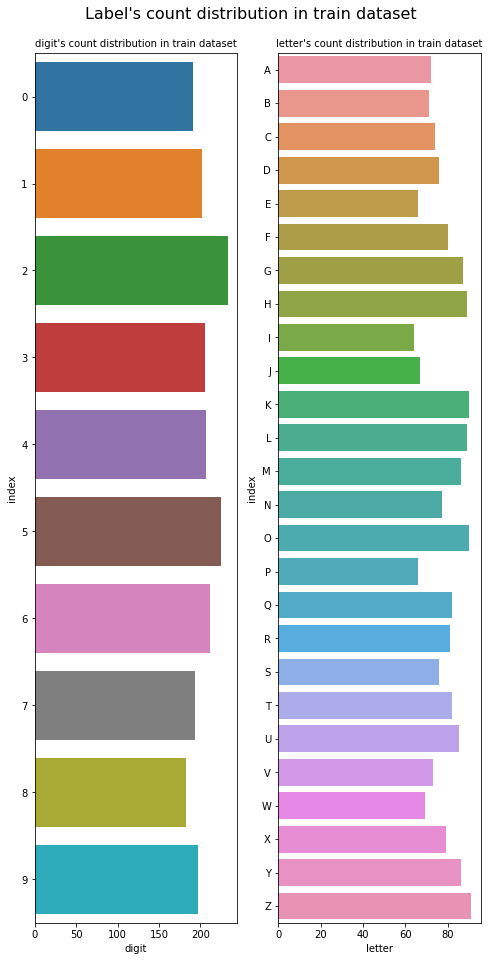

In [5]:
fig, axes = plt.subplots(figsize=[8,16],nrows=1,ncols=2)

target_cols = ["digit","letter"]

for idx, ax in enumerate(axes):

    column = target_cols[idx]
    dummy = df_train[column].value_counts().sort_index().reset_index()
    sns.barplot(data=dummy,x=column,y="index",orient='h',ax=ax,)

    ax.set_title(f"{column}'s count distribution in train dataset",fontsize=10)

plt.suptitle("Label's count distribution in train dataset",y=0.92,fontsize=16)

In [6]:
unq_letters = df_train.letter.value_counts().sort_index().index
idx_letter_dict = { idx:letter for idx, letter in enumerate(unq_letters) }
letter_idx_dict = { letter:idx for idx, letter in idx_letter_dict.items() }

### 3.2. Draw EMNIST Data

In [7]:
df_train.head()

,id,digit,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,4,4,3,0,4,3,3,3,4,4,0,0,1,1,3,4,0,4,2,0,4,0,1,3,1,0,4,1,1,3,...,4,3,4,1,3,0,0,1,3,3,3,0,3,2,2,1,0,1,0,0,3,0,0,4,2,0,3,4,1,1,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,1,4,2,0,3,4,0,0,2,3,4,0,3,4,3,0,2,2,1,4,2,3,3,4,1,2,4,2,0,3,...,4,2,3,0,0,0,0,4,3,2,2,4,2,1,1,1,3,3,1,2,4,4,4,2,2,4,4,0,4,2,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,0,2,1,3,2,2,2,4,1,1,4,1,0,1,3,4,2,2,2,4,1,1,2,0,3,0,2,3,4,0,...,3,0,4,0,3,0,2,0,1,4,2,3,4,4,4,0,2,0,4,4,1,3,0,3,2,0,2,3,0,2,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,3,4,3,1,0,3,2,2,0,3,4,1,0,4,1,2,2,3,2,2,0,2,0,3,0,3,2,4,0,0,...,0,3,0,1,4,1,3,1,2,1,1,1,2,2,2,4,3,4,3,0,4,1,2,4,1,4,0,1,0,4,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,4,2,4,2,1,4,1,1,4,4,0,2,3,4,4,3,3,3,3,4,1,0,3,0,3,0,0,0,1,1,...,2,1,3,2,1,4,2,3,2,2,1,0,4,2,2,1,2,1,0,3,2,2,2,2,1,4,2,1,2,1,4,4,3,2,1,3,4,3,1,2


In [8]:
df_imgs = df_train.loc[:,df_train.columns[3:]].values
trn_size = df_imgs.shape[0]
img_size = np.sqrt(df_imgs.shape[1]).astype("int")
img_height = img_size
img_width = img_size

760


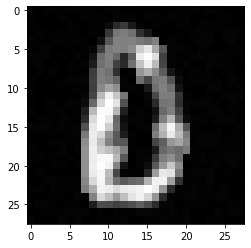

In [9]:
rand_num = np.random.randint(trn_size)
print(rand_num)
plt.imshow(df_train.loc[:,df_train.columns[3:]].iloc[rand_num].values.reshape(img_height,img_width),cmap="gray")

## 4. Data Preparation

### 4.1. Train Dataset Cross Validation & Save img to pickle per folds 
### / Test Save img to pickle per folds

In [10]:
## [Train] Dataset Cross Validation & Save img to pickle per folds
## [Test] Save img to pickle per folds

def make_folder(directory_path):
  if not os.path.isdir(directory_path):
    os.mkdir(directory_path)

IS_DATA = True
fold_size = 5
path_train = os.path.join(pj_home,'input/data/train')
path_test = os.path.join(pj_home,'input/data/test')


if IS_DATA == False:

  """ [Train] Dataset Cross Validation & Save img bits to pickle """

  kfold = StratifiedKFold(n_splits=fold_size,shuffle=True,random_state=101)
  for fold, (trn_idx, valid_idx) in enumerate(kfold.split(X=df_train,y=df_train.digit)):
    df_train.loc[valid_idx,"fold"] = fold

  df_train_imgs = df_train.loc[:,df_train.columns[3:-1]].values

  # path_train = os.path.join(pj_home,'input/data/train')
  make_folder(path_train)

  for fold in range(5):
    fold_path = os.path.join(path_train,f'{fold}')
    make_folder(fold_path)

  ## id_digit_letter 순으로 pkl명 생성
  for idx,id in tqdm_notebook(enumerate(df_train.id.values)):
    img_id = id
    fold = df_train.loc[df_train.id==img_id,"fold"].values[0]
    digit = df_train.loc[df_train.id==img_id,"digit"].values[0]
    letter = df_train.loc[df_train.id==img_id,"letter"].values[0]
    img = df_train_imgs[idx,:]
    # http://taewan.kim/tip/python_pickle/ pickle 형태 저장
    with open(os.path.join(path_train,'%d/%d_%d_%c.pkl'%(fold,img_id,digit,letter)),'wb') as f:
      pickle.dump(img,f)

  """ [Test] Save img bits to pickle """

  df_test_imgs = df_test.loc[:,df_test.columns[2:]].values
  # path_test = os.path.join(pj_home,'input/data/test')
  make_folder(path_test)

  ## id_digit_letter 순으로 pkl명 생성
  for idx,id in tqdm_notebook(enumerate(df_test.id.values)):
    img_id = id
    letter = df_test.loc[df_test.id==img_id,"letter"].values[0]
    img = df_test_imgs[idx,:]
    # http://taewan.kim/tip/python_pickle/ pickle 형태 저장
    with open(os.path.join(path_test,'%d_%c.pkl'%(img_id,letter)),'wb') as f:
      pickle.dump(img,f)

### 4.2. Load Train, Valid, Test Data from pickle

In [11]:
np.random.seed(101)
valid_fold = np.random.randint(5)
train_folds = [idx for idx in range(5) if idx != valid_fold]
print(f"Valid fold is {valid_fold} among {list(range(fold_size))}")

""" [Train] Dataset Cross Validation & Save img bits to pickle """

trn_pattern = '[0-9]+_[0-9]_[A-Z]'

trn_dict = dict()
val_dict = dict()
idx = 0
for trn_fold in train_folds:
  fold_path = os.path.join(path_train,str(trn_fold))
  for dir_name, _, file_names in os.walk(fold_path):
    for file_name in tqdm_notebook(file_names):
      img_str= re.search(trn_pattern,file_name).group()
      img_id, img_digit, img_letter = img_str.split("_")
      img_path = os.path.join(fold_path,file_name)
      # pickle data load
      with open(img_path, 'rb') as f:
        img = pickle.load(f)
        trn_dict[idx] = {"img_id":img_id, "digit":img_digit, "letter":img_letter, "img":img}
        idx +=1  

idx = 0
fold_path = os.path.join(path_train,str(valid_fold))
for dir_name, _, file_names in os.walk(fold_path):
  for file_name in tqdm_notebook(file_names):
    img_str= re.search(trn_pattern,file_name).group()
    img_id, img_digit, img_letter = img_str.split("_")
    img_path = os.path.join(fold_path,file_name)
    # pickle data load
    with open(img_path, 'rb') as f:
      img = pickle.load(f)
      val_dict[idx] = {"img_id":img_id, "digit":img_digit,"letter":img_letter, "img":img}  
      idx +=1


""" [Test] Dataset Cross Validation & Save img bits to pickle """

test_pattern = '[0-9]+_[A-Z]'

test_dict = dict()

idx = 0
for dir_name, _, file_names in os.walk(path_test):
  for file_name in tqdm_notebook(file_names):
    img_str= re.search(test_pattern,file_name).group()
    img_id, img_letter = img_str.split("_")
    img_path = os.path.join(path_test,file_name)
    # pickle data load
    with open(img_path, 'rb') as f:
      img = pickle.load(f)
      test_dict[idx] = {"img_id":img_id, "letter":img_letter, "img":img}  
      idx+=1

Valid fold is 3 among [0, 1, 2, 3, 4]


### 4.3. Argumentation

In [12]:
IMG_CHANNEL = 1

if IMG_CHANNEL == 1:
  
  train_transforms= transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
  ])
  valid_transforms = transforms.Compose([
      transforms.ToPILImage(),
      transforms.ToTensor(),
      transforms.Normalize([0.5], [0.5])
    ])

elif IMG_CHANNEL == 3:

  train_transforms = A.Compose([
          A.Rotate(20),
          A.OneOf([
              A.IAAAdditiveGaussianNoise(),
              A.GaussNoise(),
          ], p=0.2),
          A.OneOf([
              A.MotionBlur(p=.2),
              A.MedianBlur(blur_limit=3, p=0.1),
              A.Blur(blur_limit=3, p=0.1),
          ], p=0.2),
          A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
          A.OneOf([
              A.OpticalDistortion(p=0.3),
              A.GridDistortion(p=.1),
              A.IAAPiecewiseAffine(p=0.3),
          ], p=0.2),
          A.OneOf([
              A.CLAHE(clip_limit=2),
              A.IAASharpen(),
              A.IAAEmboss(),
              A.RandomBrightnessContrast(),            
          ], p=0.3),
          A.HueSaturationValue(p=0.3),
      #pytorch가 학습에 사용할 수 있는 형태로 Image를 출력(HWC -> CHW)
      ToTensor()
      ])

  valid_transforms = A.Compose([
      #pytorch가 학습에 사용할 수 있는 형태로 Image를 출력(HWC -> CHW)
      ToTensor()
      ])

### 4.4. Custom Pytorch Dataset & make dataloader

In [13]:
class Emnst_Datset(Dataset):
  def __init__(self,img_dict,img_height,img_width,transform):
    self.img_dict = img_dict
    self.img_height = img_height
    self.img_width = img_width
    self.transform = transform

  def __len__(self):
    return len(self.img_dict)

  def __getitem__(self,index):
    img_dict = self.img_dict[index]
    img_id = img_dict["img_id"]
    img = img_dict["img"].reshape(self.img_height,self.img_width)
    digit = img_dict["digit"]
    letter = img_dict["letter"]
    img = img.astype("uint8")
    # img = img[:,:,np.newaxis]
    # img = np.repeat(img,3,2)

    if self.transform is not None:
      if type(self.transform) == A.core.composition.Compose:
        img = self.transform(image=img)["image"]
      elif type(train_transforms) == transforms.Compose:
        img = self.transform(img)

    digit = np.uint8(digit)

    return img, torch.tensor(digit,dtype=torch.long)

In [14]:
trn_dataset = Emnst_Datset(img_dict=trn_dict,img_height=28,img_width=28,transform=train_transforms)
val_dataset = Emnst_Datset(img_dict=val_dict,img_height=28,img_width=28,transform=valid_transforms)

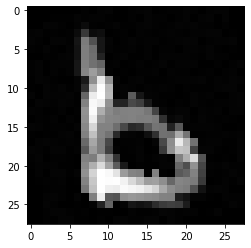

In [15]:
if IMG_CHANNEL == 1:
  plt.imshow(trn_dataset[0][0].reshape(28,28),cmap="gray")

elif IMG_CHANNEL == 3:
  plt.imshow(trn_dataset[0][0].permute(1,2,0),cmap="gray")

In [16]:
trn_loader = DataLoader(trn_dataset, batch_size=16,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16,shuffle=False)

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## 5. Make Model, Training, Prediction

In [37]:
class EMNST_CNN(nn.Module):
  def __init__(self):
    super(EMNST_CNN,self).__init__()

    # self.layer1 = self.conv_module(1,16)
    self.layer1 = self.conv_module(1,16, IS_DROPOUT=False)
    # self.layer2 = self.conv_module(16,24)
    self.layer2 = self.conv_module(16,24, IS_DROPOUT=False)
    # self.layer3 = self.conv_module(24,32)
    self.layer3 = self.conv_module(24,32, IS_DROPOUT=False)
    self.layer4 = self.conv_module(32,64, IS_DROPOUT=False)
    self.layer5 = self.conv_module(64,128, IS_DROPOUT=False)
    # self.layer4 = self.conv_module(32,64)
    # self.layer5 = self.conv_module(64,128)
    # self.fc_layer = self.global_avg_pool(128,10)
    self.fc_layer = self.global_avg_pool(128,10, IS_DROPOUT=True)
  
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)
    out = self.fc_layer(out)
    out = out.view(-1,10)

    return out

  def conv_module(self, in_num, out_num, IS_DROPOUT=True):

    if IS_DROPOUT:
      return nn.Sequential(
          nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(out_num),
          nn.LeakyReLU(),
          nn.Dropout2d(p=0.5),
          nn.MaxPool2d(kernel_size=3, stride=1)
      )
    else:
      return nn.Sequential(
          nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(out_num),
          nn.LeakyReLU(),
          nn.MaxPool2d(kernel_size=3, stride=1)
      )

  def global_avg_pool(self, in_num, out_num, IS_DROPOUT=True):

    if IS_DROPOUT:
      return nn.Sequential(
          nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(out_num),
          nn.LeakyReLU(),
          nn.Dropout2d(p=0.5),
          nn.AdaptiveAvgPool2d((1,1))
      )
    else:  
      return nn.Sequential(
          nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(out_num),
          nn.LeakyReLU(),
          nn.AdaptiveAvgPool2d((1,1))
      )

In [125]:

# construct model on cuda if available

use_cuda = torch.cuda.is_available()

class CNNClassifier(nn.Module):
    
    def __init__(self):
        # 항상 torch.nn.Module을 상속받고 시작
        super(CNNClassifier, self).__init__()
        conv1 = nn.Conv2d(1, 6, 5, 1) # 6@24*24
        # activation ReLU
        pool1 = nn.MaxPool2d(2) # 6@12*12
        conv2 = nn.Conv2d(6, 16, 5, 1) # 16@8*8
        # activation ReLU
        pool2 = nn.MaxPool2d(2) # 16@4*4
        
        self.conv_module = nn.Sequential(
            conv1,
            nn.ReLU(),
            pool1,
            conv2,
            nn.ReLU(),
            pool2
        )
        
        fc1 = nn.Linear(16*4*4, 120)
        # activation ReLU
        fc2 = nn.Linear(120, 84)
        # activation ReLU
        fc3 = nn.Linear(84, 10)

        self.fc_module = nn.Sequential(
            fc1,
            nn.ReLU(),
            fc2,
            nn.ReLU(),
            fc3
        )
        
        # gpu로 할당
        if use_cuda:
            self.conv_module = self.conv_module.cuda()
            self.fc_module = self.fc_module.cuda()
        
    def forward(self, x):
        out = self.conv_module(x) # @16*4*4
        # make linear
        dim = 1
        for d in out.size()[1:]: #16, 4, 4
            dim = dim * d
        out = out.view(-1, dim)
        out = self.fc_module(out)
        return F.softmax(out, dim=1)

In [138]:
cnn = EMNST_CNN()

In [126]:
cnn = CNNClassifier()

In [139]:
cnn

EMNST_CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(32

In [140]:
def pretraining(model,num_epochs=100):
  top_val_loss = float("inf")
  best_model_wts = copy.deepcopy(model.state_dict())
  use_cuda = torch.cuda.is_available()
  # num_batches = len(trn_loader)

  trn_loss_list = []
  val_loss_list = []

  for epoch in range(num_epochs):
      trn_loss = 0.0
      trn_corrects = 0

      for i, data in enumerate(trn_loader):
          x, label = data
          if use_cuda:
              x = x.cuda()
              label = label.cuda()
          # grad init
          optimizer.zero_grad()
          # forward propagation
          model_output = model(x)
          _, preds = torch.max(model_output,1)
          # calculate loss
          loss = criterion(model_output, label)
          # print(loss)
          running_corrects = torch.sum(preds == label.data).item()
          # back propagation 
          loss.backward()
          # weight update
          optimizer.step()
          
          # trn_loss summary
          trn_loss += loss.item() * x.size(0)
          # print(trn_loss)
          trn_corrects += running_corrects
          # del (memory issue)
          del loss
          del model_output

      trn_dataset_size = len(trn_loader.dataset)
      trn_loss = trn_loss / trn_dataset_size
      trn_acc = trn_corrects / trn_dataset_size
          
      # 학습과정 출력
      # if (i+1) % 100 == 0: # every 100 mini-batches
      with torch.no_grad(): # very very very very important!!!
          val_loss = 0.0
          val_corrects = 0
          for j, val in enumerate(val_loader):
              val_x, val_label = val
              if use_cuda:
                  val_x = val_x.cuda()
                  val_label =val_label.cuda()
              val_output = model(val_x)
              _, preds = torch.max(val_output,1)

              v_loss = criterion(val_output, val_label)
              running_corrects = torch.sum(preds == val_label.data).item()

              val_loss += v_loss * val_x.size(0)
              val_corrects += running_corrects

              del v_loss
              del val_output

      val_dataset_size = len(val_loader.dataset)
      val_loss = val_loss / val_dataset_size
      val_acc = val_corrects / val_dataset_size

      print("epoch: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | trn_acc: {:.4f} | val_acc: {:.4f}".format(
          epoch+1, num_epochs, trn_loss, val_loss, trn_acc, val_acc
      ))
      if val_loss < top_val_loss:
        print("val_score Increased to {:.4f}".format(val_loss))
        top_val_loss = val_loss     
        best_model_wts = copy.deepcopy(model.state_dict())
        
      trn_loss_list.append(trn_loss)
      val_loss_list.append(val_loss)

  model.load_state_dict(best_model_wts)
  return model

In [141]:
# import torch.optim as optim
# loss
criterion = nn.CrossEntropyLoss()
# backpropagation method
learning_rate = 1e-3
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)

In [142]:
pretrained_model = pretraining(cnn)

epoch: 1/100 | trn loss: 2.3781 | val loss: 2.2920 | trn_acc: 0.1434 | val_acc: 0.1663
val_score Increased to 2.2920
epoch: 2/100 | trn loss: 2.3116 | val loss: 2.2625 | trn_acc: 0.1672 | val_acc: 0.2005
val_score Increased to 2.2625
epoch: 3/100 | trn loss: 2.2936 | val loss: 2.2466 | trn_acc: 0.1824 | val_acc: 0.1980
val_score Increased to 2.2466
epoch: 4/100 | trn loss: 2.2769 | val loss: 2.2514 | trn_acc: 0.1867 | val_acc: 0.1760
epoch: 5/100 | trn loss: 2.2686 | val loss: 2.2094 | trn_acc: 0.1916 | val_acc: 0.2176
val_score Increased to 2.2094
epoch: 6/100 | trn loss: 2.2447 | val loss: 2.2097 | trn_acc: 0.2087 | val_acc: 0.2200
epoch: 7/100 | trn loss: 2.2185 | val loss: 2.2048 | trn_acc: 0.2154 | val_acc: 0.2176
val_score Increased to 2.2048
epoch: 8/100 | trn loss: 2.2211 | val loss: 2.2078 | trn_acc: 0.2020 | val_acc: 0.2054
epoch: 9/100 | trn loss: 2.2040 | val loss: 2.1384 | trn_acc: 0.2270 | val_acc: 0.2738
val_score Increased to 2.1384
epoch: 10/100 | trn loss: 2.2136 | va

In [143]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)
# optimizer_ft = optim.Adam(cnn.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, factor=0.1,patience=5)

In [144]:
def train_model(model, criterion, optimizer,scheduler,num_epochs=8):

  trn_info = dict()
  val_info = dict()
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  # best_acc = 0.7946

  for epoch in range(num_epochs):
    epoch_since = time.time()

    running_loss = 0
    running_corrects = 0

    model.train()

    for idx, data in enumerate(trn_loader):
      inputs, labels = data 
      
      optimizer.zero_grad()
      outputs= model(inputs)
      _, preds = torch.max(outputs,1)
      loss = criterion(outputs,labels)

      loss.backward()
      
      optimizer.step()

      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data).item()
    
    trn_dataset_size = len(trn_loader.dataset)
    trn_loss = running_loss / trn_dataset_size
    trn_acc = running_corrects / trn_dataset_size

    trn_info[epoch+1]= {"trn_loss":trn_loss,"trn_acc":trn_acc}

    model.eval()

    running_loss = 0
    running_corrects = 0

    if epoch > 0:
      scheduler.step(val_loss)

    with torch.no_grad():
      for idx, data in enumerate(val_loader):
        inputs, labels = data

        val_outputs = model(inputs)
        _, preds = torch.max(val_outputs,1)
        loss = criterion(val_outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()

      val_dataset_size = len(val_loader.dataset)
      val_loss = running_loss / val_dataset_size
      val_acc = running_corrects / val_dataset_size

      val_info[epoch+1]= {"val_loss":val_loss,"val_acc":val_acc}
    
    print("epoch: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | trn acc: {:.4f} | val acc: {:.4f}".format(
            epoch+1, num_epochs, trn_info[epoch+1]["trn_loss"], val_info[epoch+1]["val_loss"], trn_info[epoch+1]["trn_acc"], val_info[epoch+1]["val_acc"]
            ))
    if val_acc > best_acc:
      prev_best_acc = best_acc
      best_acc = val_acc
      best_model_wts = copy.deepcopy(model.state_dict())
      print("Validation Accuracy Increased from {:.4f} to {:.4f}. Saving model.....".format(prev_best_acc,best_acc))
      torch.save(model.state_dict(), os.path.join(path_train,'EMNST_CNN2_model_2.pth'))

    lr_get = get_lr(optimizer)
    print('Current learning rate : {:.8f}'.format(lr_get))

    
    epoch_elapsed = time.time() - epoch_since
    print("epoch trained in {:.0f}m {:.0f}s".format(
        epoch_elapsed // 60, epoch_elapsed % 60
    ))

  time_elapsed = time.time() - since
  print("Training complete in {:.0f}m {:.0f}s".format(
      time_elapsed // 60, time_elapsed % 60
  ))
  print("Best val Acc: {:.4f}".format(best_acc))
  
  model.load_state_dict(best_model_wts)
  return model

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group["lr"]    

In [145]:
trained_model = train_model(pretrained_model,criterion=criterion,optimizer=optimizer_ft,scheduler=exp_lr_scheduler,num_epochs=100)

epoch: 1/100 | trn loss: 1.8667 | val loss: 1.6018 | trn acc: 0.3856 | val acc: 0.6479
Validation Accuracy Increased from 0.0000 to 0.6479. Saving model.....
Current learning rate : 0.00100000
epoch trained in 0m 24s
epoch: 2/100 | trn loss: 1.9020 | val loss: 1.5746 | trn acc: 0.3655 | val acc: 0.6993
Validation Accuracy Increased from 0.6479 to 0.6993. Saving model.....
Current learning rate : 0.00100000
epoch trained in 0m 26s
epoch: 3/100 | trn loss: 1.9012 | val loss: 1.5837 | trn acc: 0.3691 | val acc: 0.6553
Current learning rate : 0.00100000
epoch trained in 0m 23s
epoch: 4/100 | trn loss: 1.9066 | val loss: 1.5676 | trn acc: 0.3734 | val acc: 0.6773
Current learning rate : 0.00100000
epoch trained in 0m 23s
epoch: 5/100 | trn loss: 1.8855 | val loss: 1.5949 | trn acc: 0.3679 | val acc: 0.6430
Current learning rate : 0.00100000
epoch trained in 0m 23s
epoch: 6/100 | trn loss: 1.8939 | val loss: 1.6002 | trn acc: 0.3691 | val acc: 0.6284
Current learning rate : 0.00100000
epoch 

In [146]:
from  torch.utils.data import Dataset

class Emnst_Datset3(Dataset):
  def __init__(self,img_dict,img_height,img_width,transform):
    self.img_dict = img_dict
    self.img_height = img_height
    self.img_width = img_width
    self.transform = transform

  def __len__(self):
    return len(self.img_dict)

  def __getitem__(self,index):
    img_dict = self.img_dict[index]
    img_id = int(img_dict["img_id"])
    img = img_dict["img"].reshape(self.img_height,self.img_width)
    letter = img_dict["letter"]
    img = img.astype("uint8")

    if self.transform is not None:
      img = self.transform(img)

    return img, torch.tensor(img_id,dtype=torch.long)

In [147]:
test_dataset2 = Emnst_Datset3(img_dict=test_dict,img_height=28,img_width=28,transform=valid_transforms)
test_loader2 = DataLoader(test_dataset2, batch_size=16,shuffle=False)

In [149]:
def test_model(model):
  
  result_dict = dict()

  with torch.no_grad():
    for input, ids in tqdm_notebook(test_loader2):
      output = model(input)
      output = torch.argmax(output,dim=1)

      ids = ids.data.numpy()
      output = output.data.numpy()
      
      for idx, id in enumerate(ids):
        result_dict[id] = output[idx]

  return result_dict
      
output = test_model(trained_model)

In [150]:
submission = pd.read_csv(os.path.join(data_home,'submission.csv'))
submission.loc[:,"digit"] = submission.id.apply(lambda x: output[x])

In [151]:
submission.head()

,id,digit
0,2049,2
1,2050,9
2,2051,5
3,2052,0
4,2053,3


In [152]:
submission.to_csv(os.path.join(data_home,'results_3.csv'),index=False)